In [5]:
%matplotlib widget
import umap
import mat73
import scipy.io as sio
import sys
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from sklearn.preprocessing import StandardScaler 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#%% functions
def skipping_average(v, skip_step=125):
    """
    v : a numerical vector
    skip_step : length of intervals; default to 100 ms (125 samples, 1250 Hz)
    """
    n_int = np.floor_divide(len(v), skip_step)
    v_ret = np.zeros(n_int)
    for i in range(n_int):
        v_ret[i] = np.nanmean(v[i*skip_step:(i+1)*skip_step])
        
    return v_ret

In [21]:
#%% parameters 
bins = 36  # bins per trial
xaxis = np.arange(bins)*10

In [39]:
#%% loading
pathname = 'Z:\Dinghao\MiceExp\ANMD063r\A063r-20230708\A063r-20230708-01'
recname = pathname[-17:]

print(recname)
    
# load distance-converted spike data for the current session
spike = mat73.loadmat('{}\{}_DataStructure_mazeSection1_TrialType1_convSpikesDistAligned_msess1_Run0.mat'.format(pathname, recname))
alignedRun = spike['filteredSpikeDistArrayRun']  # load alignedRun spike data

# load if each neurones is an interneurone or a pyramidal cell 
info = sio.loadmat('{}\{}_DataStructure_mazeSection1_TrialType1_Info.mat'.format(pathname, recname))
rec_info = info['rec'][0][0]
intern_id = rec_info['isIntern'][0]
pyr_id = [not(clu) for clu in intern_id]

# load place cell ID's 
classification = sio.loadmat('{}\{}_DataStructure_mazeSection1_TrialType1_FieldSpCorrAligned_Run1_Run0.mat'.format(pathname, recname))
place_cells = classification['fieldSpCorrSessNonStimGood'][0][0]['indNeuron'][0]

# locate baseline trials
beh_info = info['beh'][0][0]
behPar = sio.loadmat('{}\{}_DataStructure_mazeSection1_TrialType1_behPar_msess1.mat'.format(pathname, recname))
stimOn = behPar['behPar']['stimOn'][0][0][0][1:]
tot_stim = sum(stimOn)
baseline = np.arange(np.where(stimOn!=0)[0][0])

tot_dist = alignedRun[0].shape[1]  # tot distance bins 
tot_trial = alignedRun[0].shape[0]  # tot number of trials
tot_clu = len(alignedRun)

A063r-20230708-01


In [40]:
#%% put dist-spike data into an array 
X_all = np.zeros((tot_clu, bins*tot_trial))  # concatenate all together
X_stim = np.zeros((tot_clu, bins*tot_stim))
stim_count = 0
for clu in range(tot_clu):
    for t in range(tot_trial-1):
        X_all[clu, t*bins:(t+1)*bins] = skipping_average(alignedRun[clu][t+1,:1800], skip_step=50)
        if stimOn[t]==1:
            X_stim[clu, stim_count*bins:(stim_count+1)*bins] = skipping_average(alignedRun[clu][t+1,:1800], skip_step=50)

In [41]:
#%% UMAP 
reducer = umap.UMAP(metric='cosine',
                    output_metric='euclidean',
                    negative_sample_rate=5,
                    target_metric='categorical',
                    dens_lambda=2.0,
                    dens_frac=0.3,
                    dens_var_shift=0.1,
                    min_dist=0.1,
                    spread=1.0,
                    repulsion_strength=1.0,
                    learning_rate=1.0,
                    init='spectral',
                    n_neighbors=20,
                    n_components=3)

In [43]:
#%% single-trial embedding
mapper = reducer.fit(np.transpose(X_all))
X_emb = mapper.transform(np.transpose(X_all))
X_stim_emb = mapper.transform(np.transpose(X_stim))

C:\Users\luod\AppData\Local\anaconda3\envs\spyder-env\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


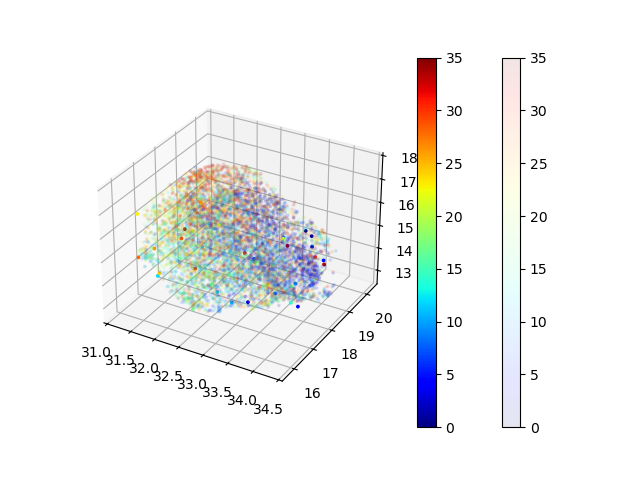

In [54]:
#%% plot 
d = list(np.arange(bins))*tot_trial  # dist for color mapping
d_stim = list(np.arange(bins))*tot_stim

fig = plt.figure()
ax = plt.axes(projection ='3d')
plot = ax.scatter(xs=X_emb[:, 0], ys=X_emb[:, 1], zs=X_emb[:, 2], s=3, c=d, cmap=cm.jet, alpha=.1)
plot_stim = ax.scatter(xs=X_stim_emb[:, 0], ys=X_stim_emb[:, 1], zs=X_stim_emb[:, 2], s=3, c=d_stim, cmap=cm.jet, alpha=1)
cbar = fig.colorbar(plot)
cbar_stim = fig.colorbar(plot_stim)

ax.set(xlim=(31, 34.5), ylim=(15.5,20.5), zlim=(12.5,18))

plt.show()

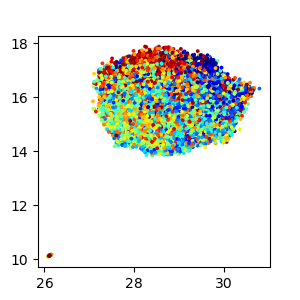

In [30]:
#%% plot 2d 
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(X_emb[:, 0], X_emb[:, 1], s=3, c=d, cmap=cm.jet)

In [53]:
X_stim_emb.shape

(1512, 3)